In [1]:
%load_ext autoreload
%autoreload 2

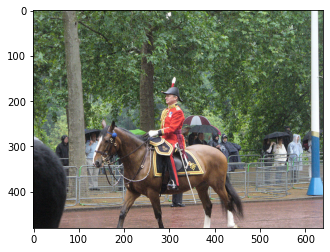

In [2]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import os
import sys
import time as time
import torch as torch
import torchvision as tv
import matplotlib.pyplot as plt


# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2.data.datasets import register_coco_instances

%matplotlib inline

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Alternative way of converting image from BGR to RGB
im = cv2.imread("../input1.jpg")[:,:,::-1]
plt.imshow(im)
plt.show()
# cv2.imshow('image', im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [3]:
print("Number of GPUs: %s" % torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print("GPU available: %s" % torch.cuda.is_available())

Number of GPUs: 1
GeForce RTX 2060
GPU available: True


In [4]:
cfg = get_cfg()
cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.merge_from_file("../configs//COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the following shorthand
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
#cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

WARNING [11/08 23:28:08 d2.config.compat]: Config '../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [5]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes

Boxes(tensor([[124.6295, 246.0557, 464.5741, 480.0000],
        [250.5952, 157.1196, 339.5726, 408.2430],
        [ 49.3507, 274.3743,  80.1645, 342.3899],
        [  0.0000, 284.6656,  78.5014, 478.5184],
        [386.0469, 270.9829, 411.8350, 303.1007],
        [334.2235, 251.3125, 414.0236, 277.6147],
        [331.4684, 231.2237, 393.7103, 257.4648],
        [561.0322, 271.5619, 594.9163, 390.1007],
        [512.4011, 276.6876, 563.4662, 389.4290],
        [329.3685, 230.3824, 402.1460, 278.3009],
        [526.8882, 277.4477, 561.6942, 344.5835],
        [114.9140, 268.0703, 145.6501, 397.1750],
        [113.1451, 267.1151, 159.3603, 395.6356]], device='cuda:0'))

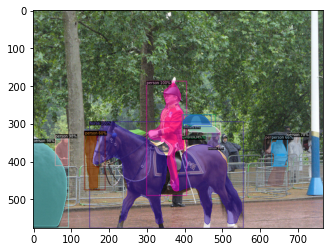

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1]) # I think get_image returns the image again in BGR and I have to convert to RBG
plt.show()

# cv2.imshow('Window', v.get_image()[:, :, ::-1])
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [7]:
# Register training dataset
train_coco_json = "F:\\downloads\\train\\train\\annos_coco\\training_coco.json"
NAME_OF_DATASET_TRAIN = "deepfashion2_train"
IMAGE_DIR_TRAIN = "F:\\downloads\\train\\train\image"
# I think it's okay to use register_coco_instances, instead of load_coco_json, because 
# it uses load_coco_json itself anyways + registers metadata with metadatacatalog_get().set()
register_coco_instances(NAME_OF_DATASET_TRAIN, {}, train_coco_json, IMAGE_DIR_TRAIN)
# Load train dataset
dataset_train_dicts = DatasetCatalog.get(NAME_OF_DATASET_TRAIN)
cloth_train_metadata = MetadataCatalog.get(NAME_OF_DATASET_TRAIN)

[11/08 23:34:04 d2.data.datasets.coco]: Loading F:\downloads\train\train\annos_coco\training_coco.json takes 301.94 seconds.
[11/08 23:34:05 d2.data.datasets.coco]: Loaded 191961 images in COCO format from F:\downloads\train\train\annos_coco\training_coco.json


In [8]:
# Register validation dataset
val_coco_json = "F:\\Downloads\\validation\\validation\\annos_coco\\validation_coco.json"
NAME_OF_DATASET_VAL = "deepfashion2_val"
IMAGE_DIR_VAL = "F:\\Downloads\\validation\\validation\\image"
register_coco_instances(NAME_OF_DATASET_VAL, {}, val_coco_json, IMAGE_DIR_VAL)
# Load validation dataset
dataset_val_dicts = DatasetCatalog.get(NAME_OF_DATASET_VAL)
cloth_val_metadata = MetadataCatalog.get(NAME_OF_DATASET_VAL)


[11/08 23:43:40 d2.data.datasets.coco]: Loading F:\Downloads\validation\validation\annos_coco\validation_coco.json takes 17.89 seconds.
[11/08 23:43:40 d2.data.datasets.coco]: Loaded 32153 images in COCO format from F:\Downloads\validation\validation\annos_coco\validation_coco.json


## Display dataset images

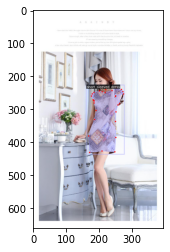

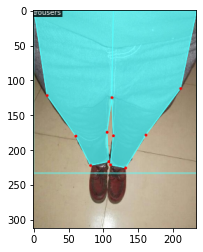

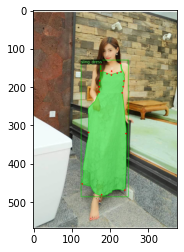

In [9]:
import random

for d in random.sample(dataset_train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cloth_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()) # I think get_image returns the image again in BGR and I have to convert to RBG
    plt.show()

## Training

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (NAME_OF_DATASET_TRAIN,)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13  # only has one class (ballon)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


WARNING [11/08 23:49:42 d2.config.compat]: Config '../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/08 23:49:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Co

## Model inference (testing)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (NAME_OF_DATASET_VAL, )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_val_dicts = DatasetCatalog.get(NAME_OF_DATASET_VAL)
for d in random.sample(dataset_val_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cloth_val_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show()


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output
